# Panama Papers: Discovery of Corruption

* Students: Ilija Gjorgjiev, Gauthier Mueller, Mahmoud Zgolli
* Dataset: Panama Papers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from py2neo import Graph, Node, Relationship
import neo4jupyter
import networkx as nx
import csv, os, sys

%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")

from pputils import *

neo4jupyter.init_notebook_mode()

%matplotlib inline


<IPython.core.display.Javascript object>

# 1. Load and convert Data

The downloaded dataset file has 5 csv files.

1/ Entity: Offshore company created in a low-tax by an offshore jurisdiction agent.

2/ Officer: Person or company who plays a role in an offshore entity.

3/ Edges : 

4/ Address: A contact postal address.

5/ Intermediary: Intermediar between someone looking for an offshore corporation and an offshore service provider.

In [2]:
#Load Data
panama_entity = pd.read_csv('./Data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
panama_officer = pd.read_csv('./Data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
panama_edges = pd.read_csv("./Data/panama_papers/panama_papers.edges.csv", low_memory=False)
panama_address = pd.read_csv("./Data/panama_papers/panama_papers.nodes.address.csv", low_memory=False)
panama_intermediary = pd.read_csv("./Data/panama_papers/panama_papers.nodes.intermediary.csv", low_memory=False)
fortune_500_comp = pd.read_csv("./Data/fortune_500_companies_US.csv", low_memory=False, encoding='latin-1')

# 2. Explore data

## 2.1 Panama entity
We First explore the entity dataset to undersand it a little bit 

In [3]:
#Convert Date/Time Values
panama_entity['incorporation_date'] = pd.to_datetime(panama_entity['incorporation_date'])
panama_entity['inactivation_date'] = pd.to_datetime(panama_entity['inactivation_date'])
#panama_entity['struck_off_date'] = pd.to_datetime(panama_entity['struck_off_date'])
panama_entity["closed_date"] = pd.to_datetime(panama_entity["closed_date"])

In [4]:
print(panama_entity.shape)
panama_entity.head(2)

(213634, 17)


,node_id,name,jurisdiction,jurisdiction_description,country_codes,countries,incorporation_date,inactivation_date,struck_off_date,closed_date,ibcRUC,status,company_type,service_provider,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",SAM,Samoa,HKG,Hong Kong,2006-03-23,2013-02-18,15-FEB-2013,NaT,25221,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",SAM,Samoa,HKG,Hong Kong,2006-03-27,2014-02-27,15-FEB-2014,NaT,25249,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN


## 2.2 Dataset

### 2.2.1 General information 

We start by getting the genral informations abot or dataset such as :

- The nationality of the Top 10 present offshore companies: We can see that Switzerlnd and Hongkong are by far the most present firm nationalities. All the present countries are developped ones.

- The nationality of the Top 15 present offshore juridiction firms: This a log plot, The british virging islands are the most preset juridiction firms.

- The evoluution of number of entities along the years: It all started around 1975 and the nmber increased exponantially. With 2 major crises in 2003 and 2010. 

- The  Top 10 present relation types:This is also a log plot, The shareholders are the most preset relations .

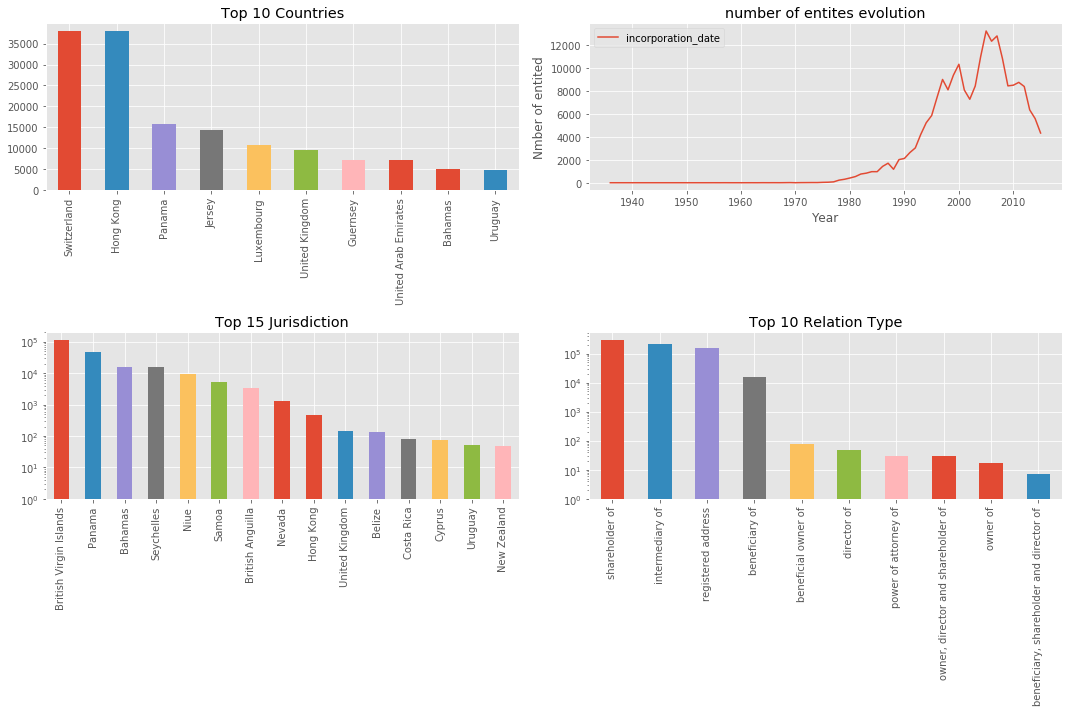

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
panama_entity["countries"].value_counts().head(10).plot.bar(title="Top 10 Countries", ax=axes[0,0])
ax=pd.DataFrame(panama_entity['incorporation_date'].dropna().dt.year.astype(int).value_counts()).sort_index().plot.line(title='number of entites evolution',ax= axes[0,1])
panama_entity["jurisdiction_description"].value_counts().head(15).plot.bar(log = True, title="Top 15 Jurisdiction", ax = axes[1,0])
panama_edges["link"].value_counts().head(10).plot.bar(log=True, title = "Top 10 Relation Type", ax = axes[1,1])
ax.set_xlabel('Year')
ax.set_ylabel('Nmber of entited')
plt.tight_layout()
plt.show()

### 2.2.2 Top 10 related entities

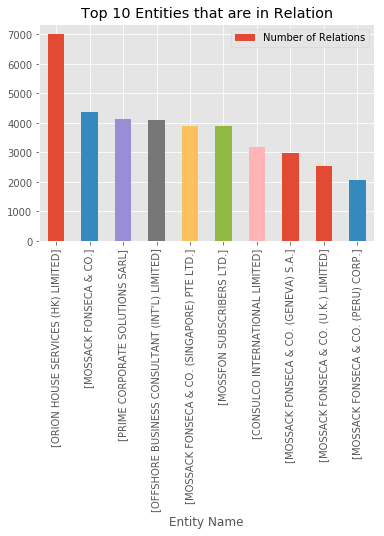

In [6]:
#Get Top 10 Entities that are in Relation
df = panama_edges.groupby('START_ID')['TYPE'].value_counts().to_frame()
df.columns = ["Number of Relations"]
df = df.sort_values(by=["Number of Relations"], ascending = False)
node_ids = df.head(10).copy()
node_ids.reset_index(inplace=True)
names = []
relations = []
#Search for them in Officers, Intermediares or Entities
for i in range(0, 10):
    name = ""
    relations.append(node_ids.loc[i, "TYPE"])
    ID = node_ids.loc[i, "START_ID"]
    if ID in panama_entity["node_id"].values:
        name = panama_entity[panama_entity["node_id"] == ID]["name"]
        names.append(name)
    elif ID in panama_intermediary["node_id"].values:
        name = panama_intermediary[panama_intermediary["node_id"] == ID]["name"]
        names.append(name)
    elif ID in panama_officer["node_id"].values:
        name = (panama_officer[panama_officer["node_id"] == ID]["name"])
        names.append(name)
    else:
        name = panama_address[panama_address["node_id"] == ID]["address"]
        names.append(name)

node_ids["Entity Name"] = pd.Series(names)
node_ids.plot.bar(x = "Entity Name", y = "Number of Relations", title = "Top 10 Entities that are in Relation")

In [7]:
#As we can see most of them are intermediaries.
node_ids.head(10) 


,START_ID,TYPE,Number of Relations,Entity Name
0,11001746,intermediary_of,7016,1756 ORION HOUSE SERVICES (HK) LIMITED Name...
1,11011863,intermediary_of,4364,"11862 MOSSACK FONSECA & CO. Name: name, dty..."
2,11012037,intermediary_of,4117,12039 PRIME CORPORATE SOLUTIONS SARL Name: ...
3,11001708,intermediary_of,4094,1722 OFFSHORE BUSINESS CONSULTANT (INT'L) L...
4,11008027,intermediary_of,3888,8031 MOSSACK FONSECA & CO. (SINGAPORE) PTE ...
5,12160432,officer_of,3882,"159573 MOSSFON SUBSCRIBERS LTD. Name: name,..."
6,11009351,intermediary_of,3168,9351 CONSULCO INTERNATIONAL LIMITED Name: n...
7,11007372,intermediary_of,2986,7369 MOSSACK FONSECA & CO. (GENEVA) S.A. Na...
8,11011539,intermediary_of,2538,11543 MOSSACK FONSECA & CO. (U.K.) LIMITED ...
9,11009139,intermediary_of,2055,9145 MOSSACK FONSECA & CO. (PERU) CORP. Nam...


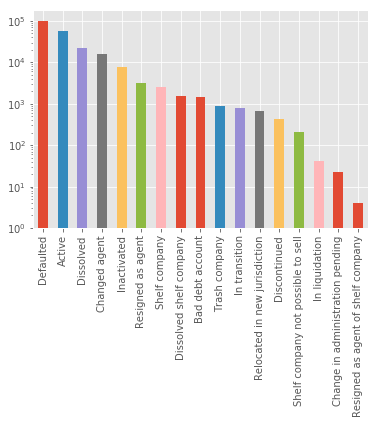

In [8]:
#Top 10 Statuses of Entities
panama_entity["status"].value_counts().plot.bar(log=True)

# 3. Correlation between countries and some indexes
Our reserach question was to find a common point between between the most citied countries. For this reason, in this section we will be calculationg the correlation bbetween the frequencty of eachy co!untry presence in the papers and some general indexes.

## 3.1 Generarl function to plot data from WORLD BANK
The world bank is a is aplateforme where one can find all kind if indices https://data.worldbank.org/ . This function is used to plot the indexes found in this plateforme. 

In [9]:
def data_read(data_name,frequency,log_on,freq_limit,idx_limit,how):
    apiBase = "http://api.worldbank.org/indicator/"
    apiIndicator = data_name    # This can be changed to any other indicator
    source = apiBase+apiIndicator+"?format=csv"
    #Import gini index data
    raw_data = pd.read_csv(source)
    #Datawrangling
    lst =[str(x) for x in range(1960,2018)]
    mean_data=pd.DataFrame()
    mean_data['Country']=raw_data['Country Name']
    if how=='mean':
        mean_data['IDX']=raw_data[lst].mean(axis=1) # take the mean over the years 
    else:
        mean_data['IDX']=raw_data[how]
    mean_data['IDX']=pd.to_numeric(mean_data['IDX'])    # take the mean over the years 
    #merge gini with frequency 
    freq_data = pd.merge(frequency,mean_data,how='inner').dropna()
    #only countries existing more than 100 times
    freq_data =freq_data[freq_data['frequency'].apply(lambda x: x>freq_limit[0]  ) & freq_data['frequency'].apply(lambda x: x<freq_limit[1] )]
    freq_data =freq_data[freq_data['IDX'].apply(lambda x: x>idx_limit[0]) &  freq_data['IDX'].apply(lambda x: x<idx_limit[1])]
    #plot the gini index vs frquency 
    freq_data[['IDX','frequency']].plot(kind='scatter',loglog=log_on, x='IDX', y='frequency', grid=True,figsize=(14,5))
    slope, intercept, r_value, p_value, std_err = stats.linregress(freq_data['IDX'], freq_data['frequency'])
    plt.plot(freq_data['IDX'], intercept + slope*freq_data['IDX'], 'r', label='fitted line')
    #correlation and p values 
    print(r_value) 
    print(p_value)

## 3.2 Frequency of the countries.
First of all we start by calculationg the frequency of each country presence in the officers, intermediary, entity and address datasets. These frequency will be used later. 

In [10]:
#Calculte the frequency of the country in the:
#officers dataset
officer_frequency=pd.DataFrame(panama_officer["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})
#intermediary dataset
intermediar_frequency=pd.DataFrame(panama_intermediary["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})
#Enctity dataset
entity_frequency=pd.DataFrame(panama_entity["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})
#Address dataset
address_frequency=pd.DataFrame(panama_entity["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})

## 3.3 Gini index
The first Index is the Gini index and indicates the developmment and economic situation of a country. Here we plot frequency as a function of the index of each country.  We also print the corrleation and the p. 

0.3033447438744689
0.08116139880782364
-0.19124281997003212
0.6812404893878952
0.05046873495485609
0.8280112795702466
0.05046873495485609
0.8280112795702466


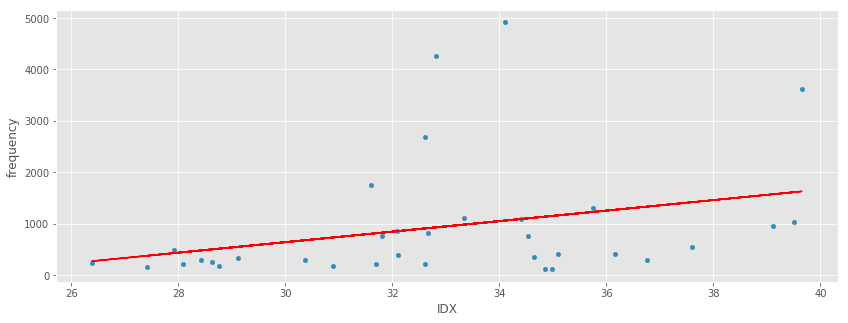

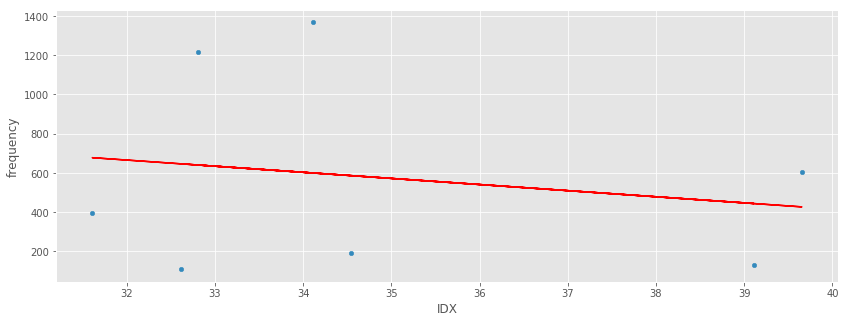

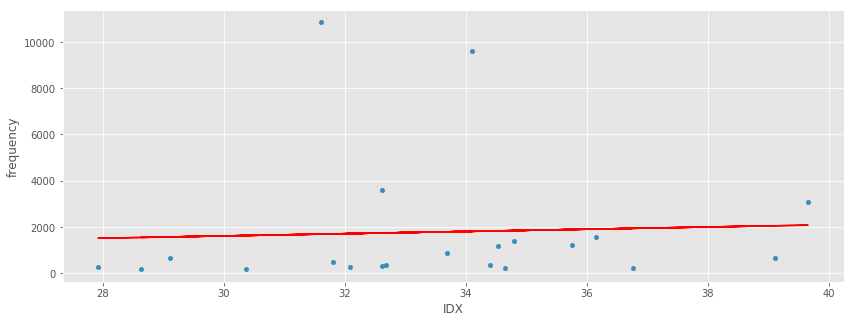

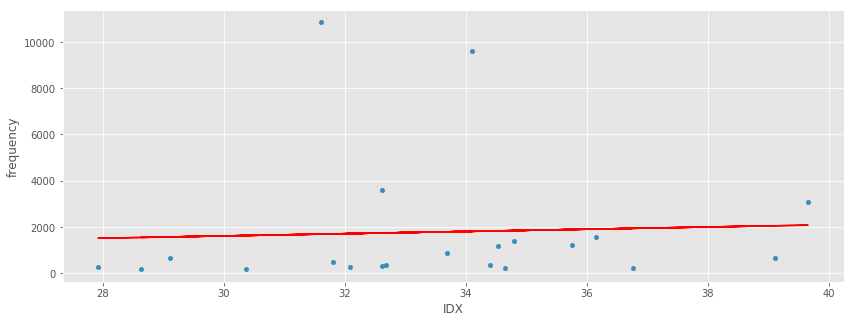

In [11]:
data_name="SI.POV.GINI"
log_on=False
freq_limit=[100,37000]
idx_limit=[0,40]
how='mean'
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,intermediar_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,entity_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,address_frequency,log_on,freq_limit,idx_limit,how)

## 3.4 Corruption index 

The second index is the perceived corruption index. 

0.15258150069295007
0.05971505305561448


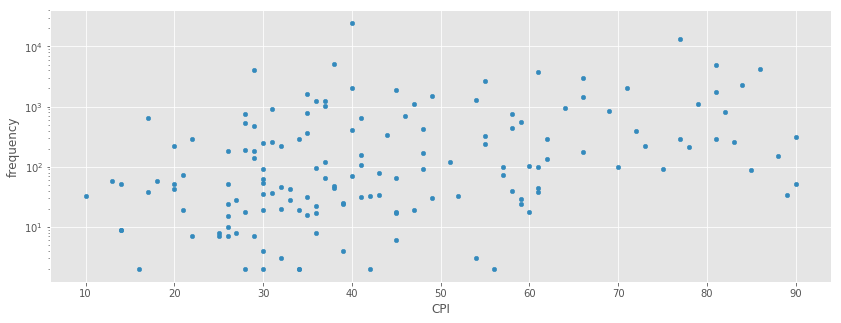

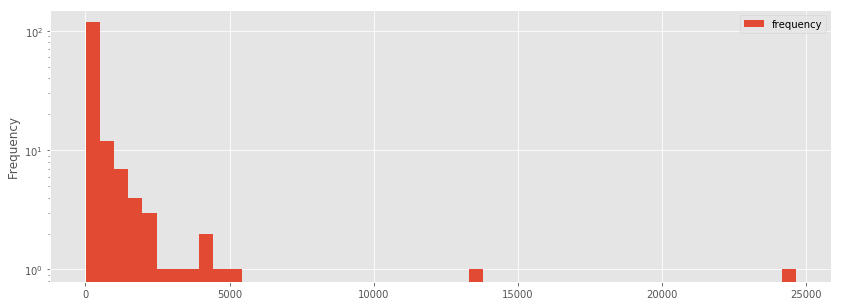

In [12]:
frequency=pd.DataFrame(panama_officer["countries"].value_counts()).reset_index().rename(index=str, columns={"index": "Country", "countries": "frequency"})
#Import corruption index data
corruption_index = pd.read_csv("./Data/corruption_index.csv", low_memory=False, encoding='latin-1')
#Corruption Data change indices names  
corr_index=corruption_index[['Country','CPI']]
#merge with frequency 
freq_corruption = pd.merge(frequency,corr_index,how='inner')
#only countries existing more than 100 times
freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x>1)]
#plot the corruption index vs frquency 
freq_corruption[['CPI','frequency']].plot(kind='scatter',logy=True, x='CPI', y='frequency', grid=True,figsize=(14,5))
freq_corruption[['CPI','frequency']].plot(kind='hist',bins=50,logy=True, x='CPI', y='frequency', grid=True,figsize=(14,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_corruption.CPI, freq_corruption.frequency)
#plt.plot(freq_corruption.CPI, intercept + slope*freq_corruption.CPI, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

## 3.5 Peace index

0.050203803549052496
0.6866120340772542


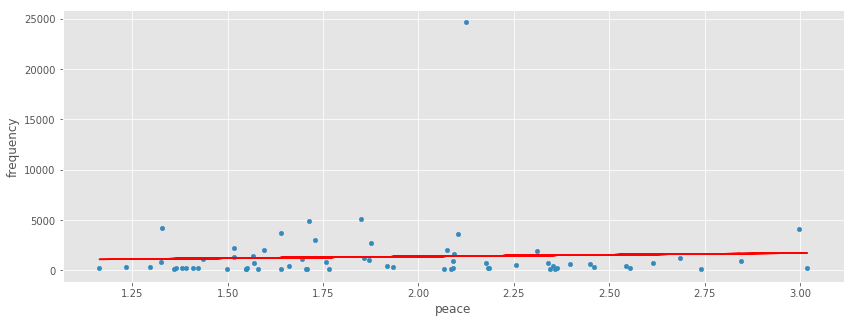

In [13]:
#Import peace index dataset
peace_index = pd.read_csv("./Data/gpi_2008-2016.csv", low_memory=False)
#select the country and the mean of peace index from 2008 to 2016
peace_index=peace_index[['Country','peace']]
#merge peace with frequency 
freq_peace = pd.merge(frequency,peace_index,how='inner')
#only countries existing more than 100 times
freq_peace =freq_peace[freq_peace['frequency'].apply(lambda x: x>100)]
#plot the peace index vs frquency 
freq_peace[['peace','frequency']].plot(kind='scatter', x='peace', y='frequency', grid=True,figsize=(14,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_peace.peace, freq_peace.frequency)
plt.plot(freq_peace.peace, intercept + slope*freq_peace.peace, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

## 3.6 Foreign direct investment as  % of GDP

-0.00013300495264433304
0.9987199101065337
0.05014844583430126
0.6349799805719873
0.28359015596867054
0.002805928056337732
0.28359015596867054
0.002805928056337732


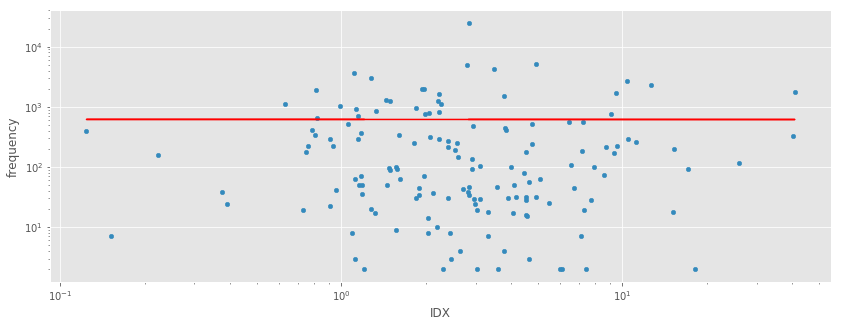

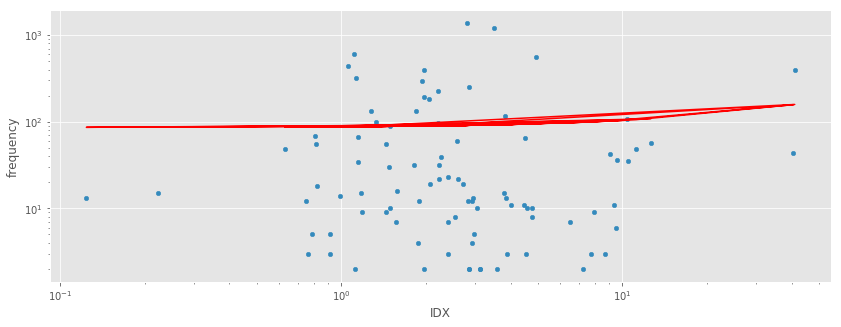

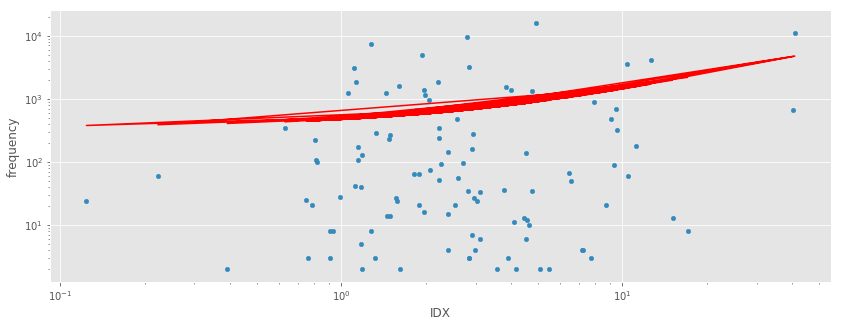

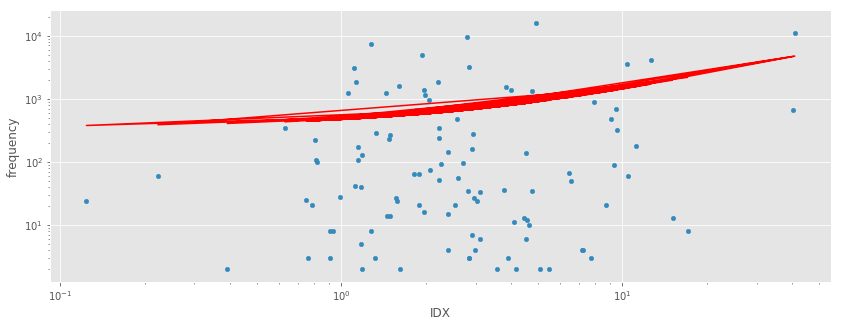

In [14]:
data_name="BX.KLT.DINV.WD.GD.ZS"
log_on=True
freq_limit=[1,37000]
idx_limit=[0,300]
how='mean'
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,intermediar_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,entity_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,address_frequency,log_on,freq_limit,idx_limit,how)

## 3.7 Insurance and financial services (% of service exports, BoP)


0.14244352892122583
0.25019189196740843
0.8552321143140006
4.823695548506357e-05
0.29838659158591124
0.05195281196610553
0.29838659158591124
0.05195281196610553


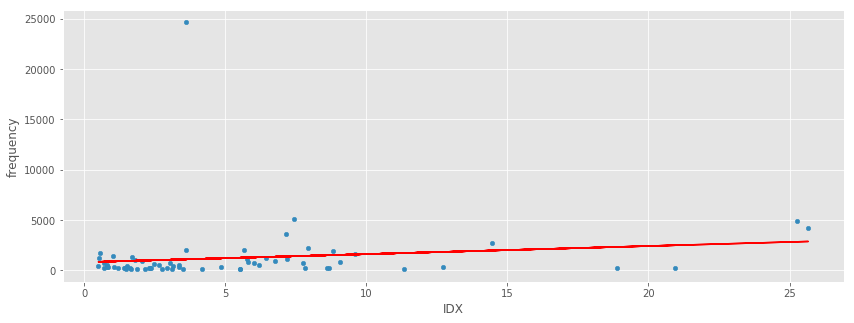

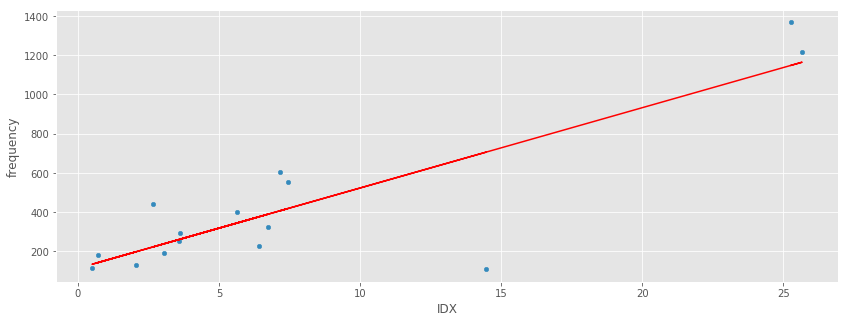

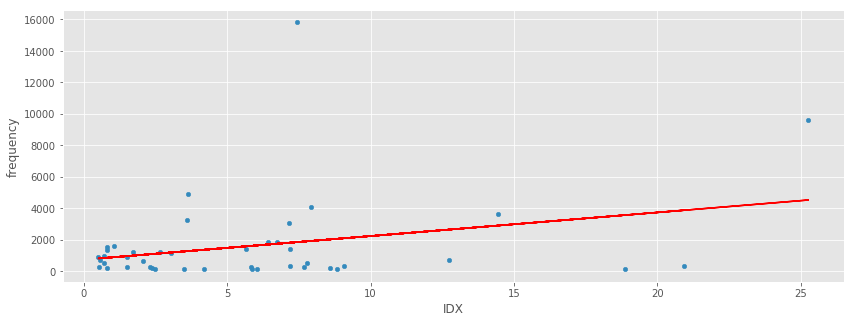

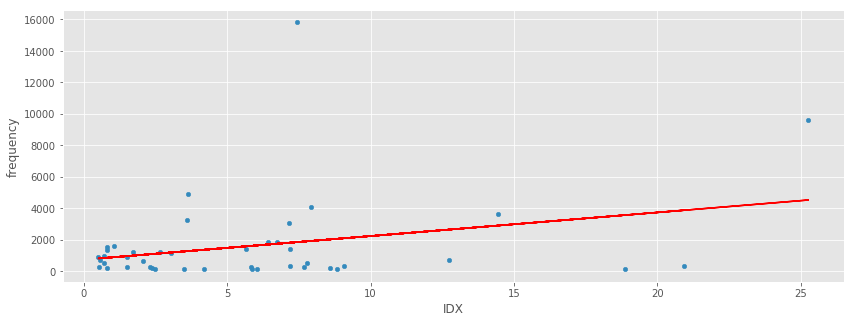

In [15]:
data_name="BX.GSR.INSF.ZS"
log_on=False
freq_limit=[100,37000]
idx_limit=[0,40]
how='mean'
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,intermediar_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,entity_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,address_frequency,log_on,freq_limit,idx_limit,how)

## 3.8 Service exports (BoP, current US dolar)

0.3411489860550787
2.859952572879209e-05
0.37050662154982217
0.00032486012736411026
0.23846270495245628
0.013830512860241614
0.23846270495245628
0.013830512860241614


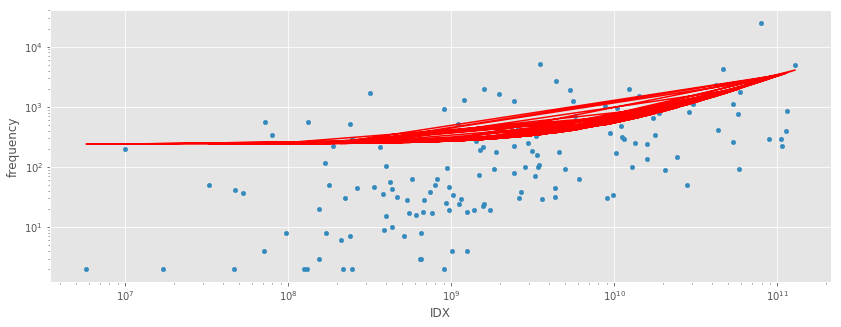

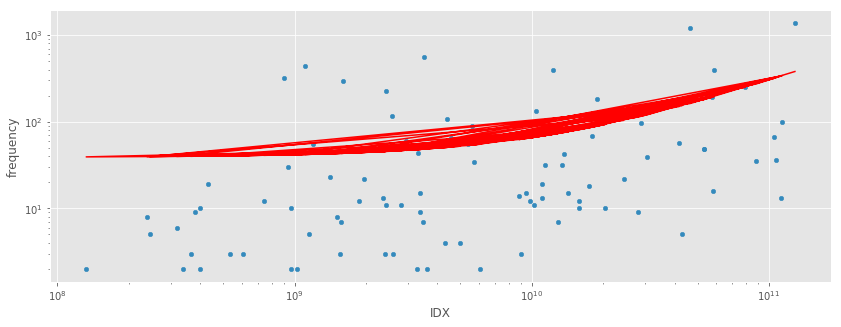

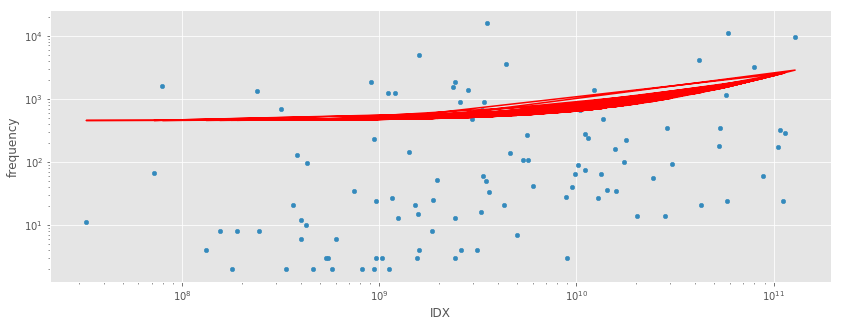

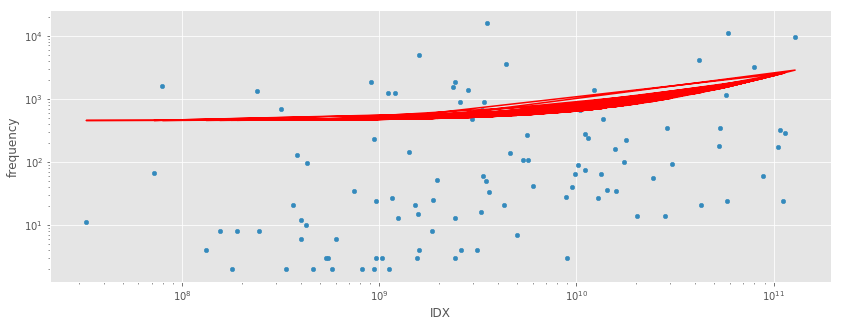

In [16]:
data_name="BX.GSR.NFSV.CD" 
log_on=True
freq_limit=[1,37000]
idx_limit=[0,2e11]
how='mean'
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,intermediar_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,entity_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,address_frequency,log_on,freq_limit,idx_limit,how)

## 3.9 Corruption VS Services 

0.5458846576026938
7.216328423040093e-13
5.3958364008190535e-11


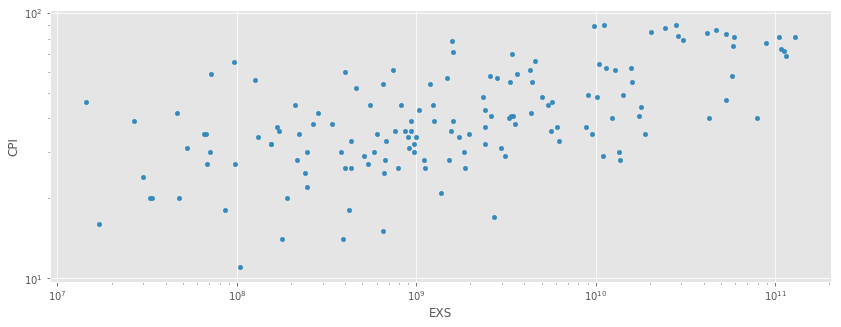

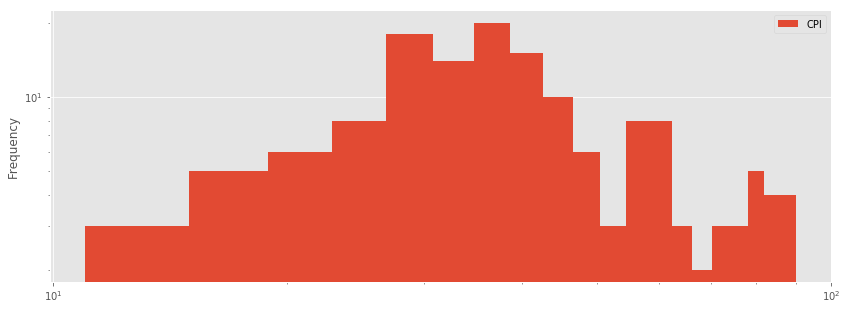

In [17]:
# Building query to fetch data from API
apiBase = "http://api.worldbank.org/indicator/"
apiIndicator4 = "BX.GSR.NFSV.CD"    # This can be changed to any other indicator
source4 = apiBase+apiIndicator4+"?format=csv"
#Import gini index data
exp_s = pd.read_csv(source4)
#Datawrangling
lst =[str(x) for x in range(1960,2018)]
exp_service=pd.DataFrame()
exp_service['Country']=exp_s['Country Name']
exp_service['EXS']=exp_s[lst].mean(axis=1) # take the mean over the years 
exp_service['EXS']=pd.to_numeric(exp_service['EXS'])    # take the mean over the years 

        
corrup_service = pd.merge(corr_index,exp_service,how='inner').dropna()
#plot the gini index vs frquency 
corrup_service =corrup_service[corrup_service['CPI'].apply(lambda x: x>0.1)]
corrup_service =corrup_service[corrup_service['EXS'].apply(lambda x: x< 2e11)]
corrup_service[['CPI','EXS']].plot(kind='scatter', x='EXS', y='CPI',loglog=True, grid=True,figsize=(14,5))
corrup_service[['CPI','EXS']].plot(kind='hist',bins=20, x='EXS', y='CPI',loglog=True, grid=True,figsize=(14,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(corrup_service['EXS'], corrup_service['CPI'])
#plt.plot(corrup_service['EXS'], intercept + slope*corrup_service['EXS'], 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)
print(std_err)

## 3.10 Humand D I vs frequency 

0.11778657797364323
0.3175656883868323


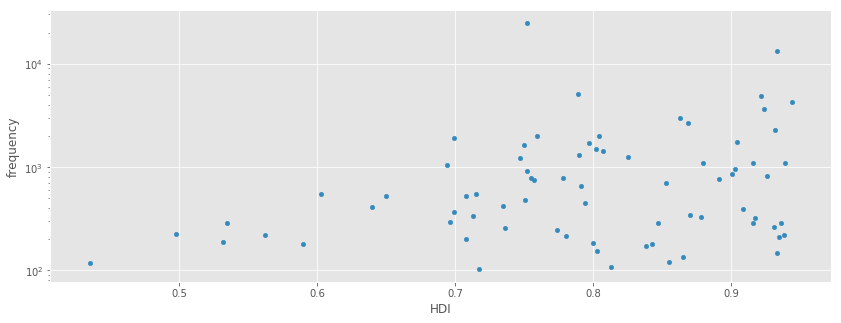

In [18]:
#Import HDi index dataset
dev = pd.read_csv("./Data/2018_Statistical_Annex_Table_1.csv", encoding='latin-1',header=6)
#select the country and the HDI index
dev_index=pd.DataFrame()
dev_index['HDI']=pd.to_numeric(dev['HDI'])
dev_index['Country']=dev['Country']
#merge HDI with frequency 
freq_hdi = pd.merge(frequency,dev_index,how='inner')
#only countries existing more than 100 times
freq_hdi =freq_hdi[freq_hdi['frequency'].apply(lambda x: x>100)]

freq_hdi=freq_hdi.dropna()
#plot the HDI index vs frquency 
freq_hdi[['HDI','frequency']].plot(kind='scatter',logy=True, x='HDI', y='frequency', grid=True,figsize=(14,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(freq_hdi.HDI, freq_hdi.frequency)
#plt.plot(freq_hdi.HDI, intercept + slope*freq_hdi.HDI, 'r', label='fitted line')
#correlation and p values 
print(r_value)
print(p_value)

## 3.11 TAX Percentage

0.25367492317621204
0.01584199418912573
0.10980287472756334
0.3877385415367538
0.08155602480375884
0.48970416310999365
0.08155602480375884
0.48970416310999365


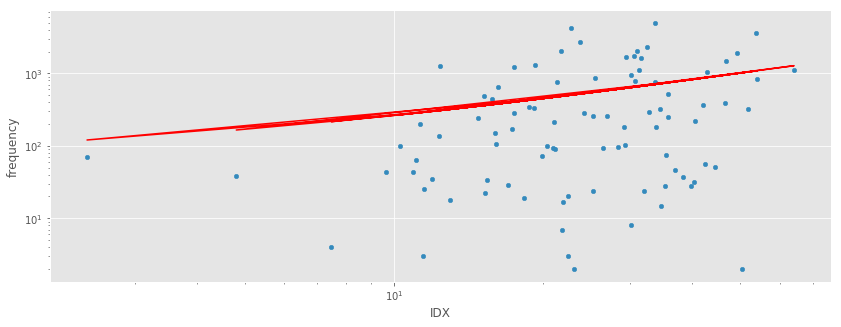

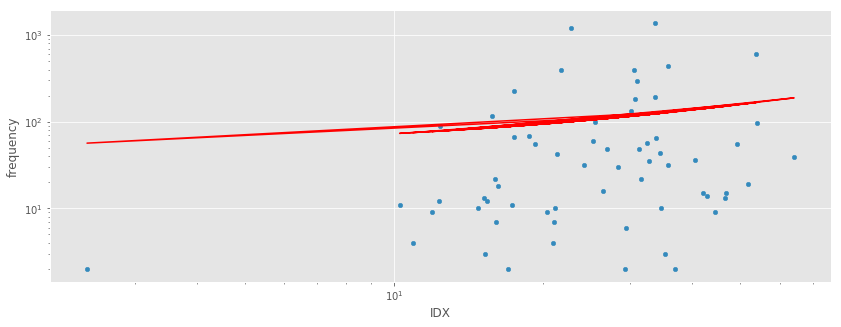

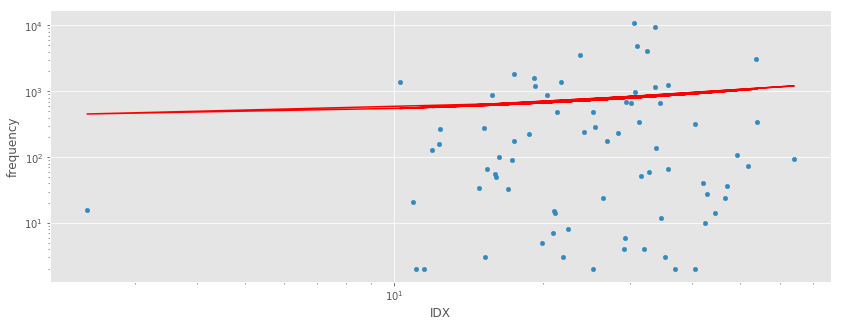

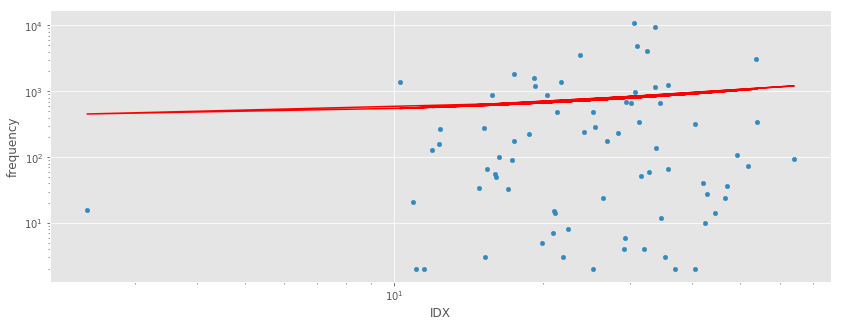

In [19]:
data_name="GC.TAX.YPKG.RV.ZS"
log_on=True
freq_limit=[1,35000]
idx_limit=[0,1000]
how='2016'
data_read(data_name,officer_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,intermediar_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,entity_frequency,log_on,freq_limit,idx_limit,how)
data_read(data_name,address_frequency,log_on,freq_limit,idx_limit,how)

# 4. Politicians 

##  4.1 Import list of politicians

In [20]:
politician_countries = pd.read_csv("./Data/power_players.csv",encoding='latin-1')
politician_countries = politician_countries.drop(columns=["Unnamed: 0"]).rename(index=str, columns={"Countries": "Country"})
politician_countries['Country']=politician_countries['Country'].str.title()
politician_countries.iloc[29,1] = "Cote d'Ivoire"
politician_countries.iloc[35,1] = "The Democratic Republic of Congo"
politician_countries.iloc[58,1] = "The Democratic Republic of Congo"
politician_corruption = pd.merge(politician_countries,corr_index,how='inner')
#freq_corruption =freq_corruption[freq_corruption['frequency'].apply(lambda x: x<35000)]

### 4.1.1 Distribution of politicians countries w.r.t corruption index

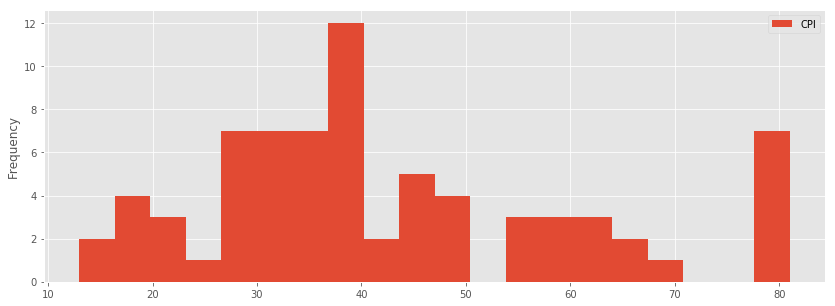

In [21]:
#only countries existing more than 100 times
freq_corruption =politician_corruption[politician_corruption['CPI'].apply(lambda x: x>1)]
#plot the corruption index vs frquency 
freq_corruption[['CPI','Country']].plot(kind='hist',bins=20, grid=True,figsize=(14,5))

### 4.1.2 Politician exact names in the Panama papers

In [22]:
politician = pd.read_csv("./Data/politicians.csv",encoding='latin-1')
freq_pol=pd.DataFrame(politician['name'].value_counts()).reset_index().rename(index=str, columns={"index": "Politicians", "name": "frequency"})
freq_pol['Politicians']=freq_pol['Politicians'].str.lower()
freq_pol['Politicians']=freq_pol['Politicians'].str.title()
df=pd.DataFrame()
df=pd.merge(freq_corruption,freq_pol,how='inner')

In [23]:
politician.dropna()
politician.to_csv('panama_politicians.csv')
politician['name'].value_counts().shape

(75,)

In [24]:
panama_officer[panama_officer["name"].str.contains("Nordal",na=False)]

,node_id,name,country_codes,countries,sourceID,valid_until,note
238397,15006701,Ólöf Nordal,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,Record manually added from leaked documents


# 5. Creation of The Graph

First we create the full graph. The edges are directed connections, as they give out information about who is shareholder of, intermediate of, director of, etc. Nodes can be any of addresses, entities, intermediates or officers. This is due to the fact that an entity should have a legal address, and then intermediaries or officers can be person, companies, foundations, etc.

In [25]:
# create graph
G = nx.DiGraph()

for n,row in panama_address.iterrows():
    G.add_node(row.node_id, node_type="address", details=row.to_dict())
    
for n,row in panama_entity.iterrows():
    G.add_node(row.node_id, node_type="entities", details=row.to_dict())
    
for n,row in panama_intermediary.iterrows():
    G.add_node(row.node_id, node_type="intermediates", details=row.to_dict())
    
for n,row in panama_officer.iterrows():
    G.add_node(row.node_id, node_type="officers", details=row.to_dict())
    
for n,row in panama_edges.iterrows():b
    G.add_edge(row['START_ID'], row['END_ID'], rel_type=row.TYPE, details=row.to_dict())

IndentationError: unexpected indent (<ipython-input-25-6523f2662486>, line 17)

In [ ]:
nx.write_adjlist(G,"pp_graph.adjlist")

### Exploring connections of Fortune 500 Companies with Panama Papers

In this subsection we will explore the connections of Fortune 500 Companies with the Panama Papers. 

In [ ]:
#Explore Forture 500 companies, if they are somehow connected to offshore companies.
fortune_500_comp.head(2)

In [ ]:
fortune_500_names = fortune_500_comp["Company Name"].values
fortune_500_names = [x.lower() for x in fortune_500_names]

#Check in Entities
for name in fortune_500_names:
    p = panama_entity[(panama_entity["country_codes"] == "USA") & (panama_entity["name"].str.lower().str.contains(name, na=False))]["name"]
    if not p.empty:
        print("Fortune 500 Name:", name)
        print(p)



* It is actually difficult to understand if these companies are somehow correlated or not from the data that we have. But we found that there is an entity under the name TESLA Foundation and MOSAIC INTERNATIONAL INC. registered under USA country code, which maybe correlated to TESLA or MOSAIC, that is why we decided to dig up a little bit on that.

In [ ]:
#Tesla Foundation and MOSAIC INTERNATIONAL INC.
panama_entity[panama_entity["name"].isin(["TESLA FOUNDATION", "MOSAIC INTERNATIONAL INC."])]

In [ ]:
#Unfortunatelly the Entity is not connected to anything.
teslaGraph = G.subgraph(nx.shortest_path(G, 10168981))
plot_graph(teslaGraph, figsize=(15,12), label_edges=True)

In [ ]:
#Unfortunatelly the Entity is not connected to anything.
mosaicGraph = G.subgraph(nx.shortest_path(G, 10065968))
plot_graph(mosaicGraph, figsize=(15,12), label_edges=True)

### Network of King Salman bin Abdulaziz bin Abdulrahman Al Saud - King of Saudi Arabia
In this subsection we will explore the connection of big player name that was found in the panama papers. We will expore the network of King of Saudi Arabia - Salman bin Abdulaziz bin Abdulrahman Al Saud. 

In [ ]:
#Explore Network for Tax Evasion Comapnies that are surronded around King Salman bin Abdulaziz bin Abdulrahman Al Saud
kingSaudiArabia = "King Salman bin Abdulaziz bin Abdulrahman Al Saud"

#Check if he actually exists in the data.
panama_officer[panama_officer["name"] == kingSaudiArabia]

In [ ]:
#Create a subgraph(connected component, which will shows with what nodes does the king interact) by BFS
kingGraph = G.subgraph(nx.shortest_path(G, 15004501))
plot_graph(kingGraph, figsize=(15,12), label_edges=True)

As we can see the King is connected to a couple of companies all having almost the same name(probably are the same company) which are being officers, the company address is in Luxembourg. these companies are then connected to actual offshore entities. We can see that this SAFASON CORPORATION SPF is connected to various other entties VERSE DEVELOPMENT CORP, CRASSUS LIMITED, PARK PROPERTY LIMITED, CRASSUS LIMITED.

In [ ]:
#Expore VERSE DEVELOPENT CORP, 
listOfEntities = ["VERSE DEVELOPMENT CORP.", "PARK PROPERTY LIMITED", "INROW CORPORATION", "CRASSUS LIMITED"] 
display(panama_entity[panama_entity["name"].isin(listOfEntities)])

We can see that Verse Development Corp. was incorporated in 1991 in Panama, under the country Jordan, in fact all of the companies are under country Jordan. All of the entities are a still activate, and they are residing in 2 jurisdictions Panama and British Virgin Islands.

## Milestone 3

For milestone 3 we are going to finish answering the questions we chose to keep. For the correlation between social-economical condition and tax evasion we are going to use additional information, Human Development Index, Global Peace Index and Corruption Perception Index. 
Next, we are going to improve the visualization of the data by presenting a data story about the correlation between countries and shells. 

# 6. References

[1] https://github.com/Roussaky/ada-EPFL/blob/master/project/project_notebook.ipynb

[2] https://github.com/REDeLapp/Panama-Papers-Network-Analysis

[3] https://github.com/amaboura/panama-papers-dataset-2016